# Analysis and visualization of spatial transcriptomics data

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8,8))
sc.settings.verbosity = 3

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                 10.1.0
asttokens           NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           0.8.3
h5py                3.10.0
igraph              0.11.3
ipykernel           6.25.0
jedi                0.18.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.41.1
matplotlib          3.8.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.26.2
packaging           23.2
pandas              2.1.3
parso               0.8.3
patsy               0.5.4
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.0.36
psutil              5.9.0
ptyprocess          0.7.0
pure_eval           0.2.2
pydev_ipython   

## Reading the data

Use a Visium spatial transcriptomics dataset of the human lymphnode, which is available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node)

[datasets.visium_sge()](https://scanpy.readthedocs.io/en/latest/generated/scanpy.datasets.visium_sge.html) downloads the dataset from 10x Genomics and returns an `AnnData` object with counts, images, and spatial coordinates. Calculate standards QC metrics with [pp.calcuate_qc_metrics](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.calculate_qc_metrics.html) and percentage of mitochondrial read counts per sample. 

When using your own Visium data, use [sc.read.visium()](https://scanpy.readthedocs.io/en/latest/generated/scanpy.read_visium.html) to import it.

In [3]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

reading /home/mesqueda/projects/scanpy/github/spatial_transcriptomics_data/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


How the adata structure looks like for Visium data

In [4]:
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

## QC and preprocessing

Some basic filtering of spots based on total counts and expressed genes

/tmp/ipykernel_24494/1125004840.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_24494/1125004840.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=4

<Axes: xlabel='n_genes_by_counts'>

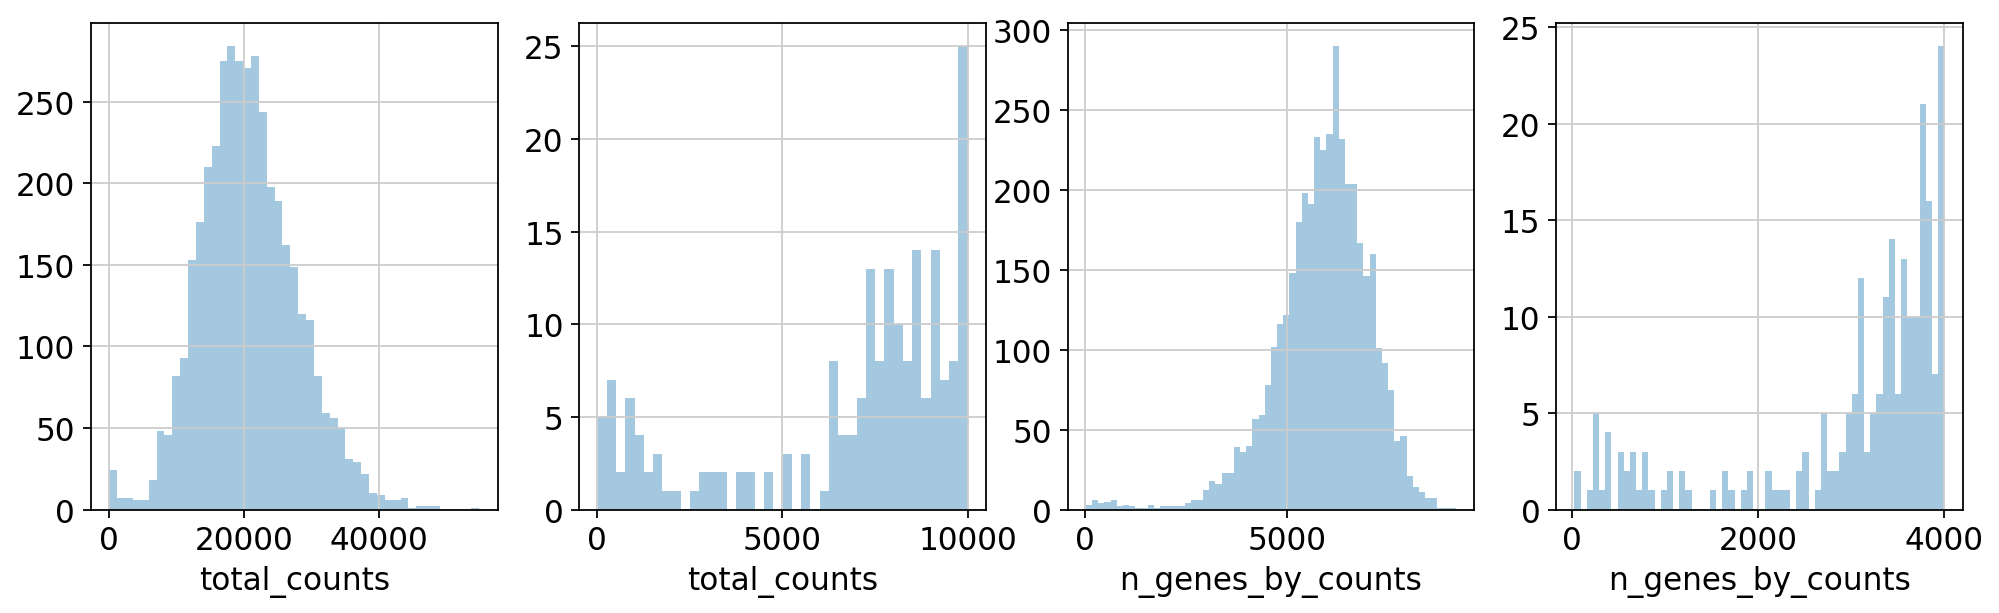

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [6]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 44 cells that have less than 5000 counts
filtered out 130 cells that have more than 35000 counts
cells after MT filter: 3861
filtered out 16916 genes that are detected in less than 10 cells


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Normalize Visuium counts data with `normalize_total` method from Scanpy, and detect highly-variable genes (alternatives include [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) and [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6).

In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Manifold embedding and clustering based on transcriptional similarity

To embed and cluster the manifold encoded by transcriptional similarity, proceed with the standard clustering tutorial.

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


Plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes.

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


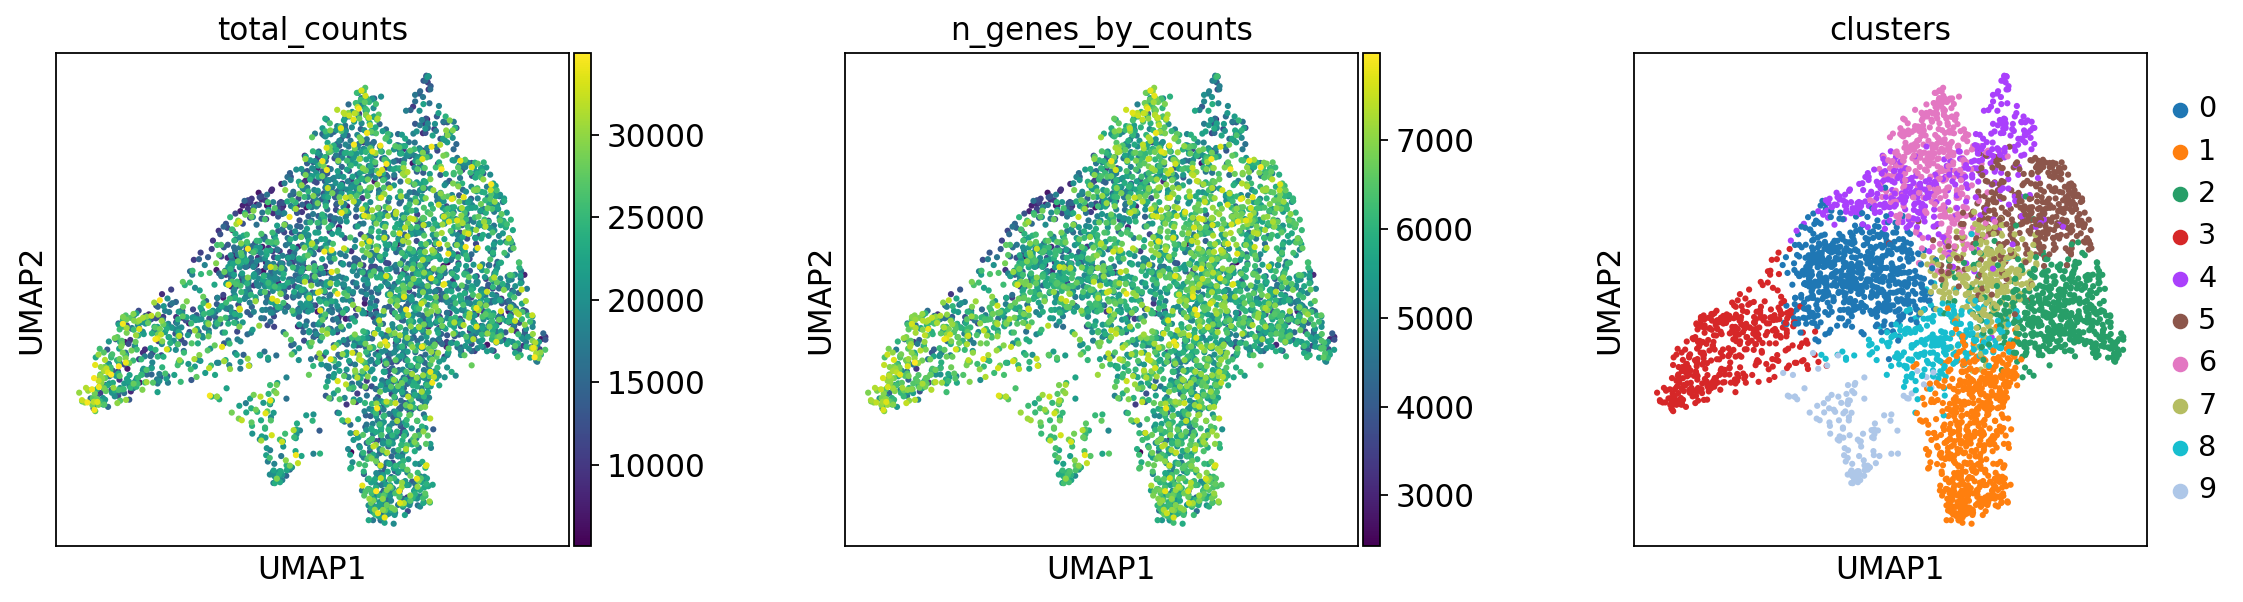

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

## Visualization in spatial coordinates

Look at how `total_counts` and `n_genes_by_counts` behave in spatial coordinates. Overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using [sc.pl.spatial](https://scanpy.readthedocs.io/en/latest/generated/scanpy.pl.spatial.html)

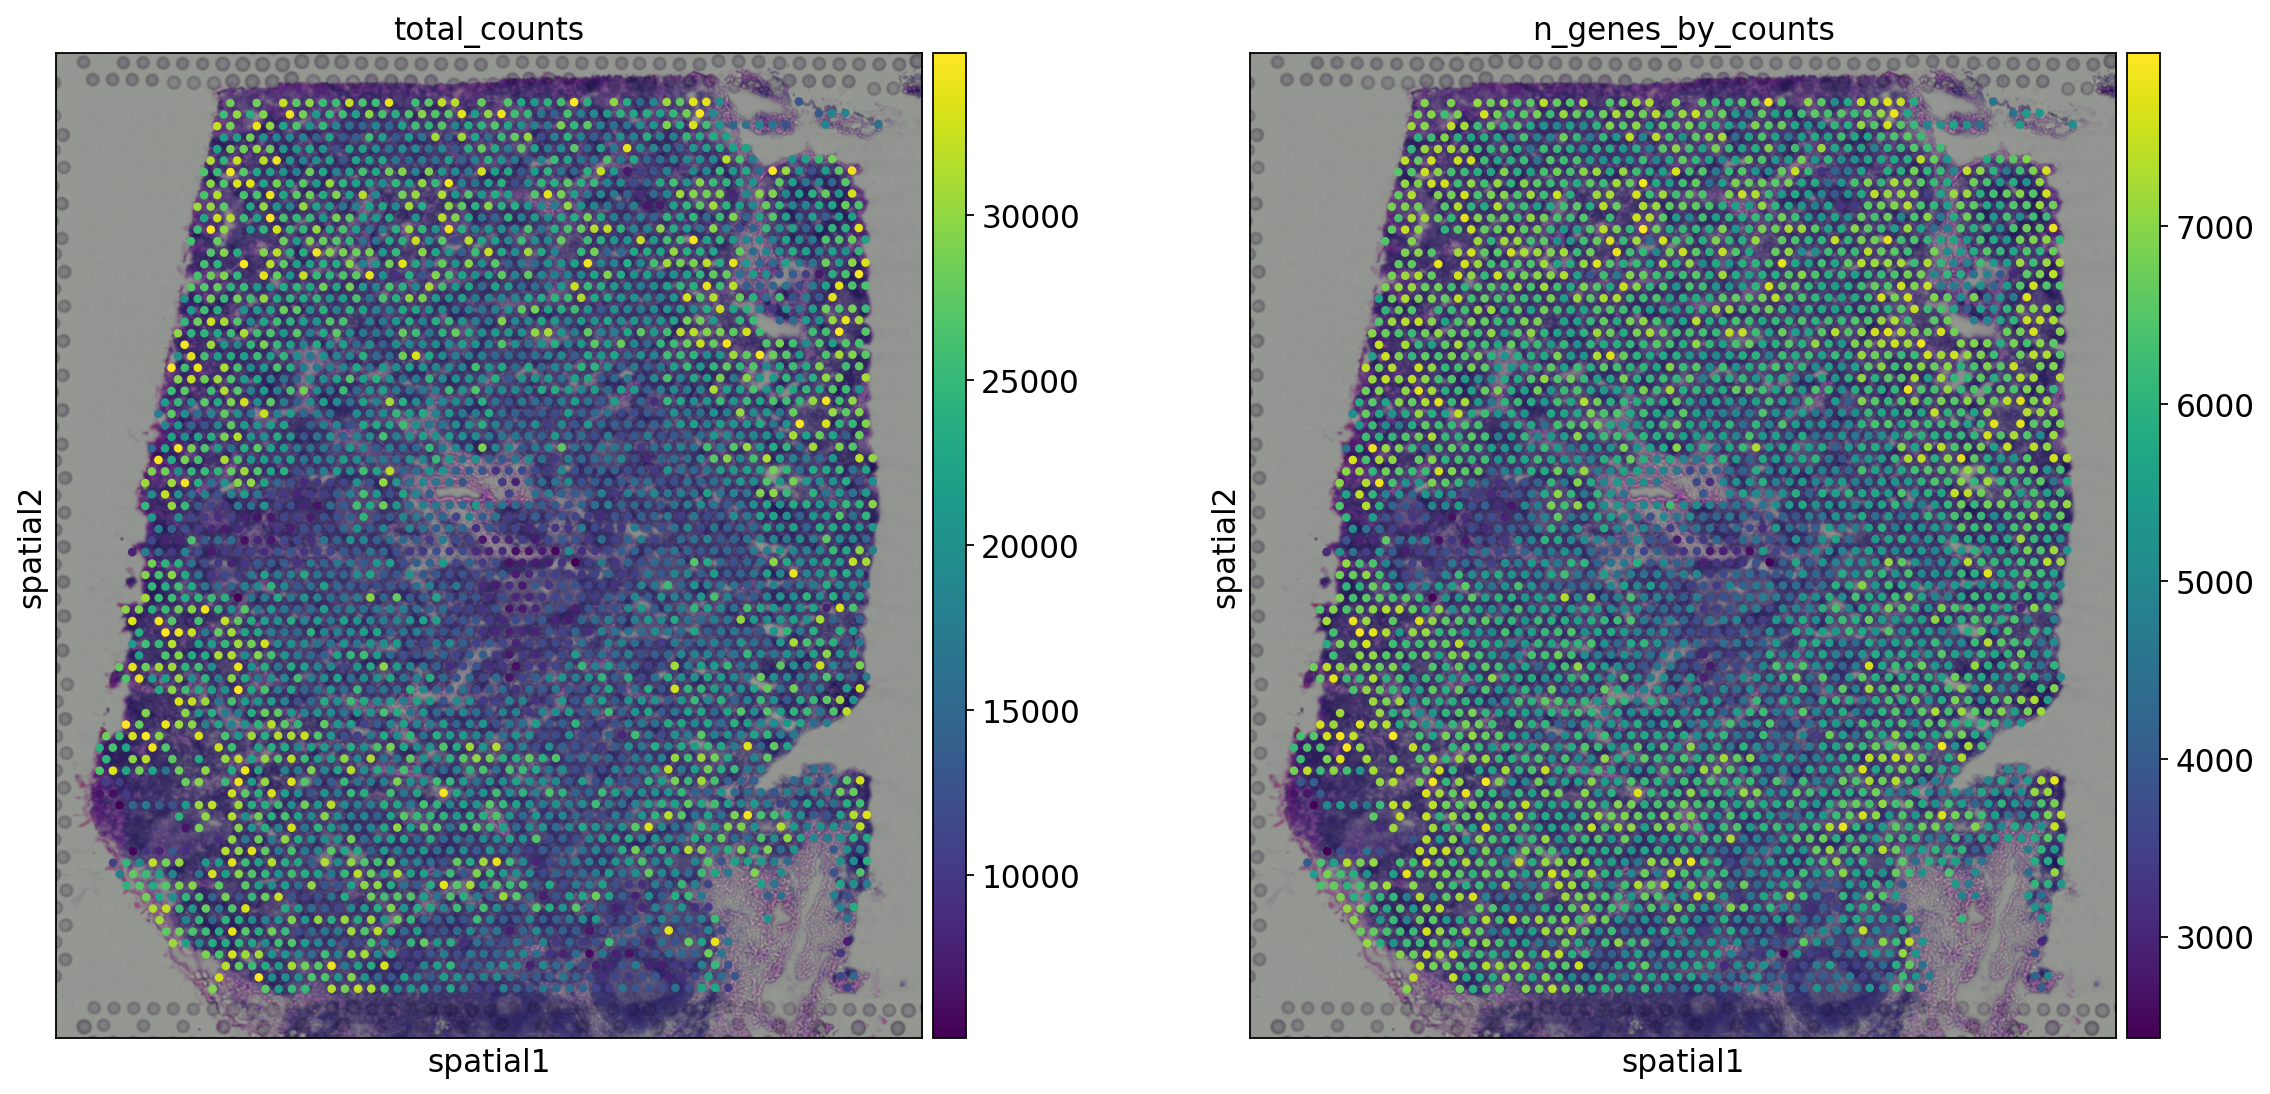

In [10]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

By visualizing clustered samnples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.

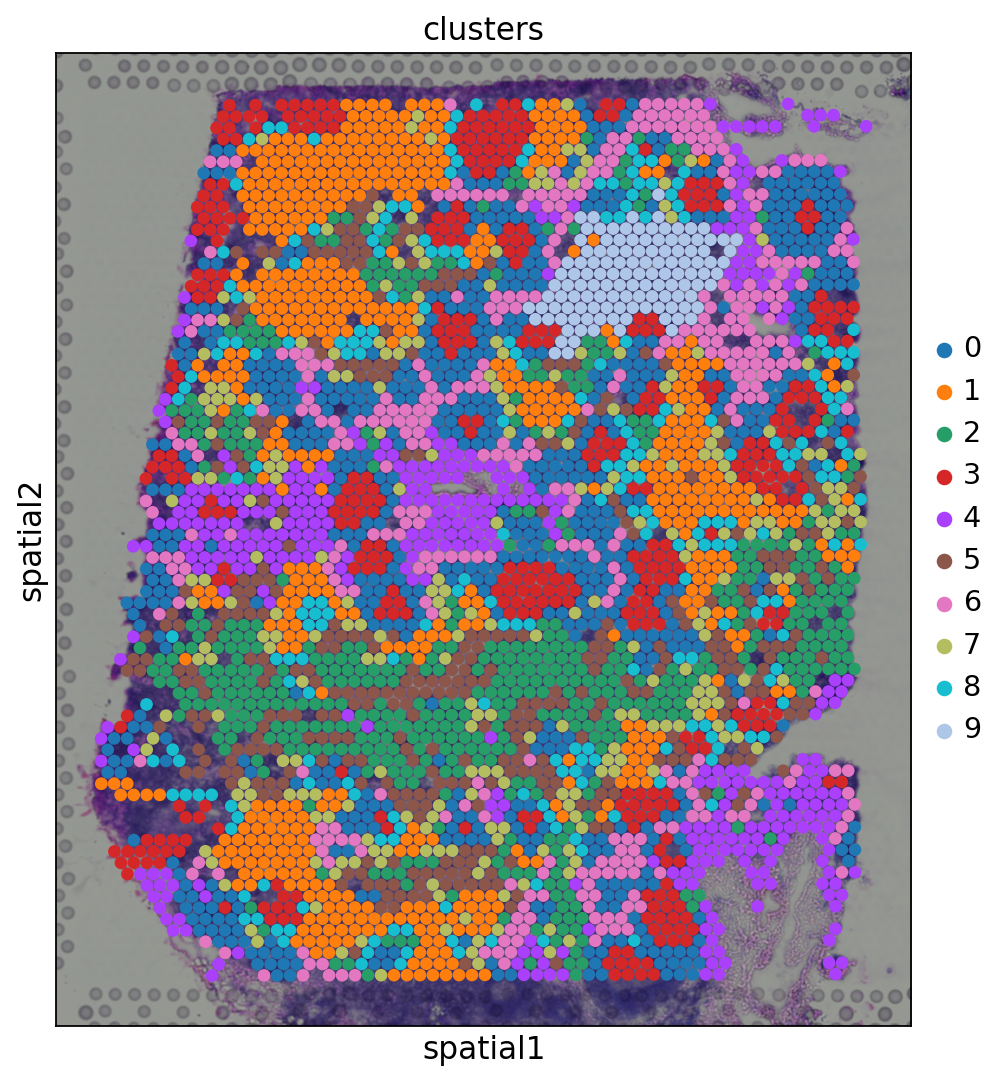

In [11]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

Spots belonging to the same cluster in gene expression space often co-occur in spatial dimensions. 

Zoom into specific regions of interests to gain qualitative insights. By changing the alpha values of the spots, we can visualize better the underlying tissue morphology from the H&E image.

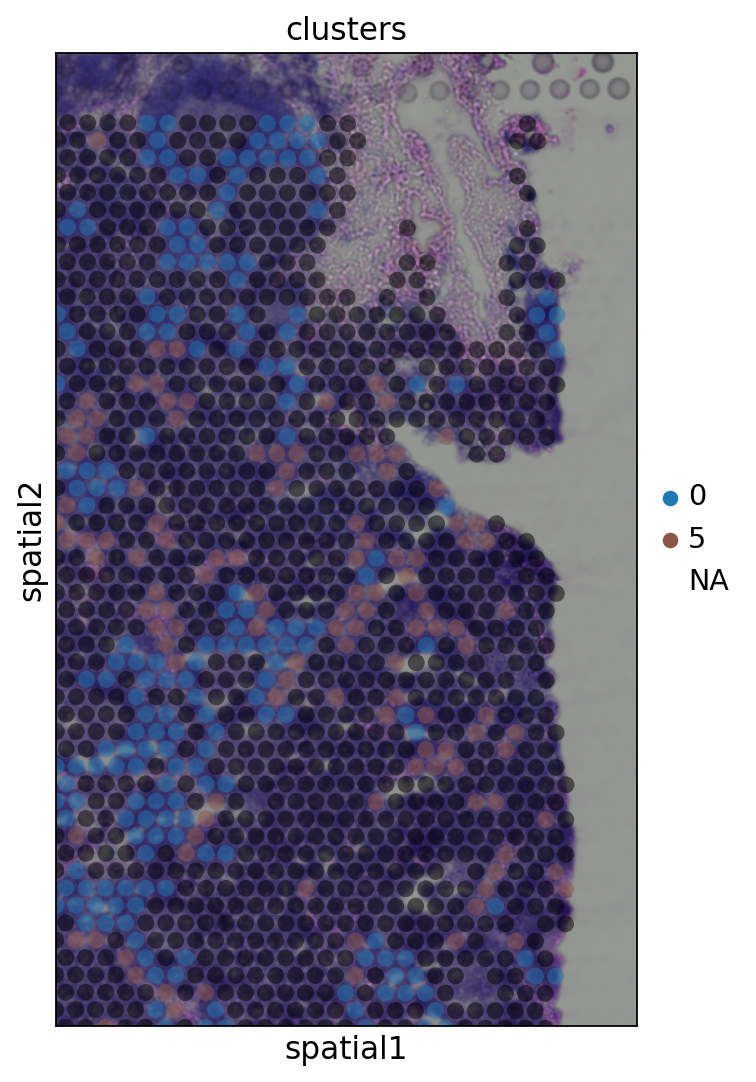

In [45]:
sc.pl.spatial(adata, img_key="hires", color="clusters", groups=["0", "5"], crop_coord=[6000, 10000, 10700, 4000],alpha=0.5, size=1.3)

## Cluster marker genes

Further inspect cluster 5

Compute marker gens and plot a heatmap with expression levels of its top 10 marker genes across clusters

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


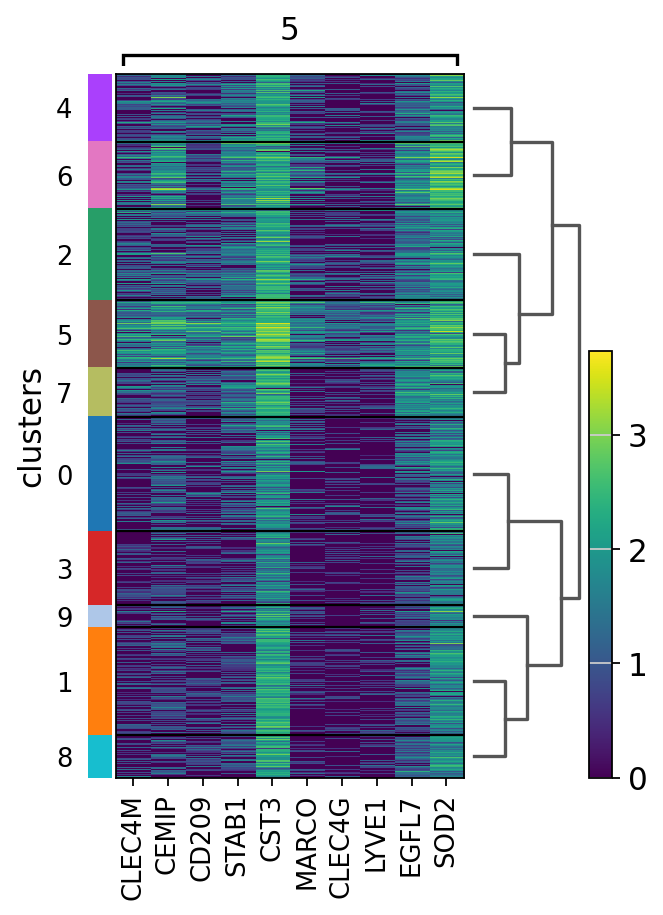

In [13]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

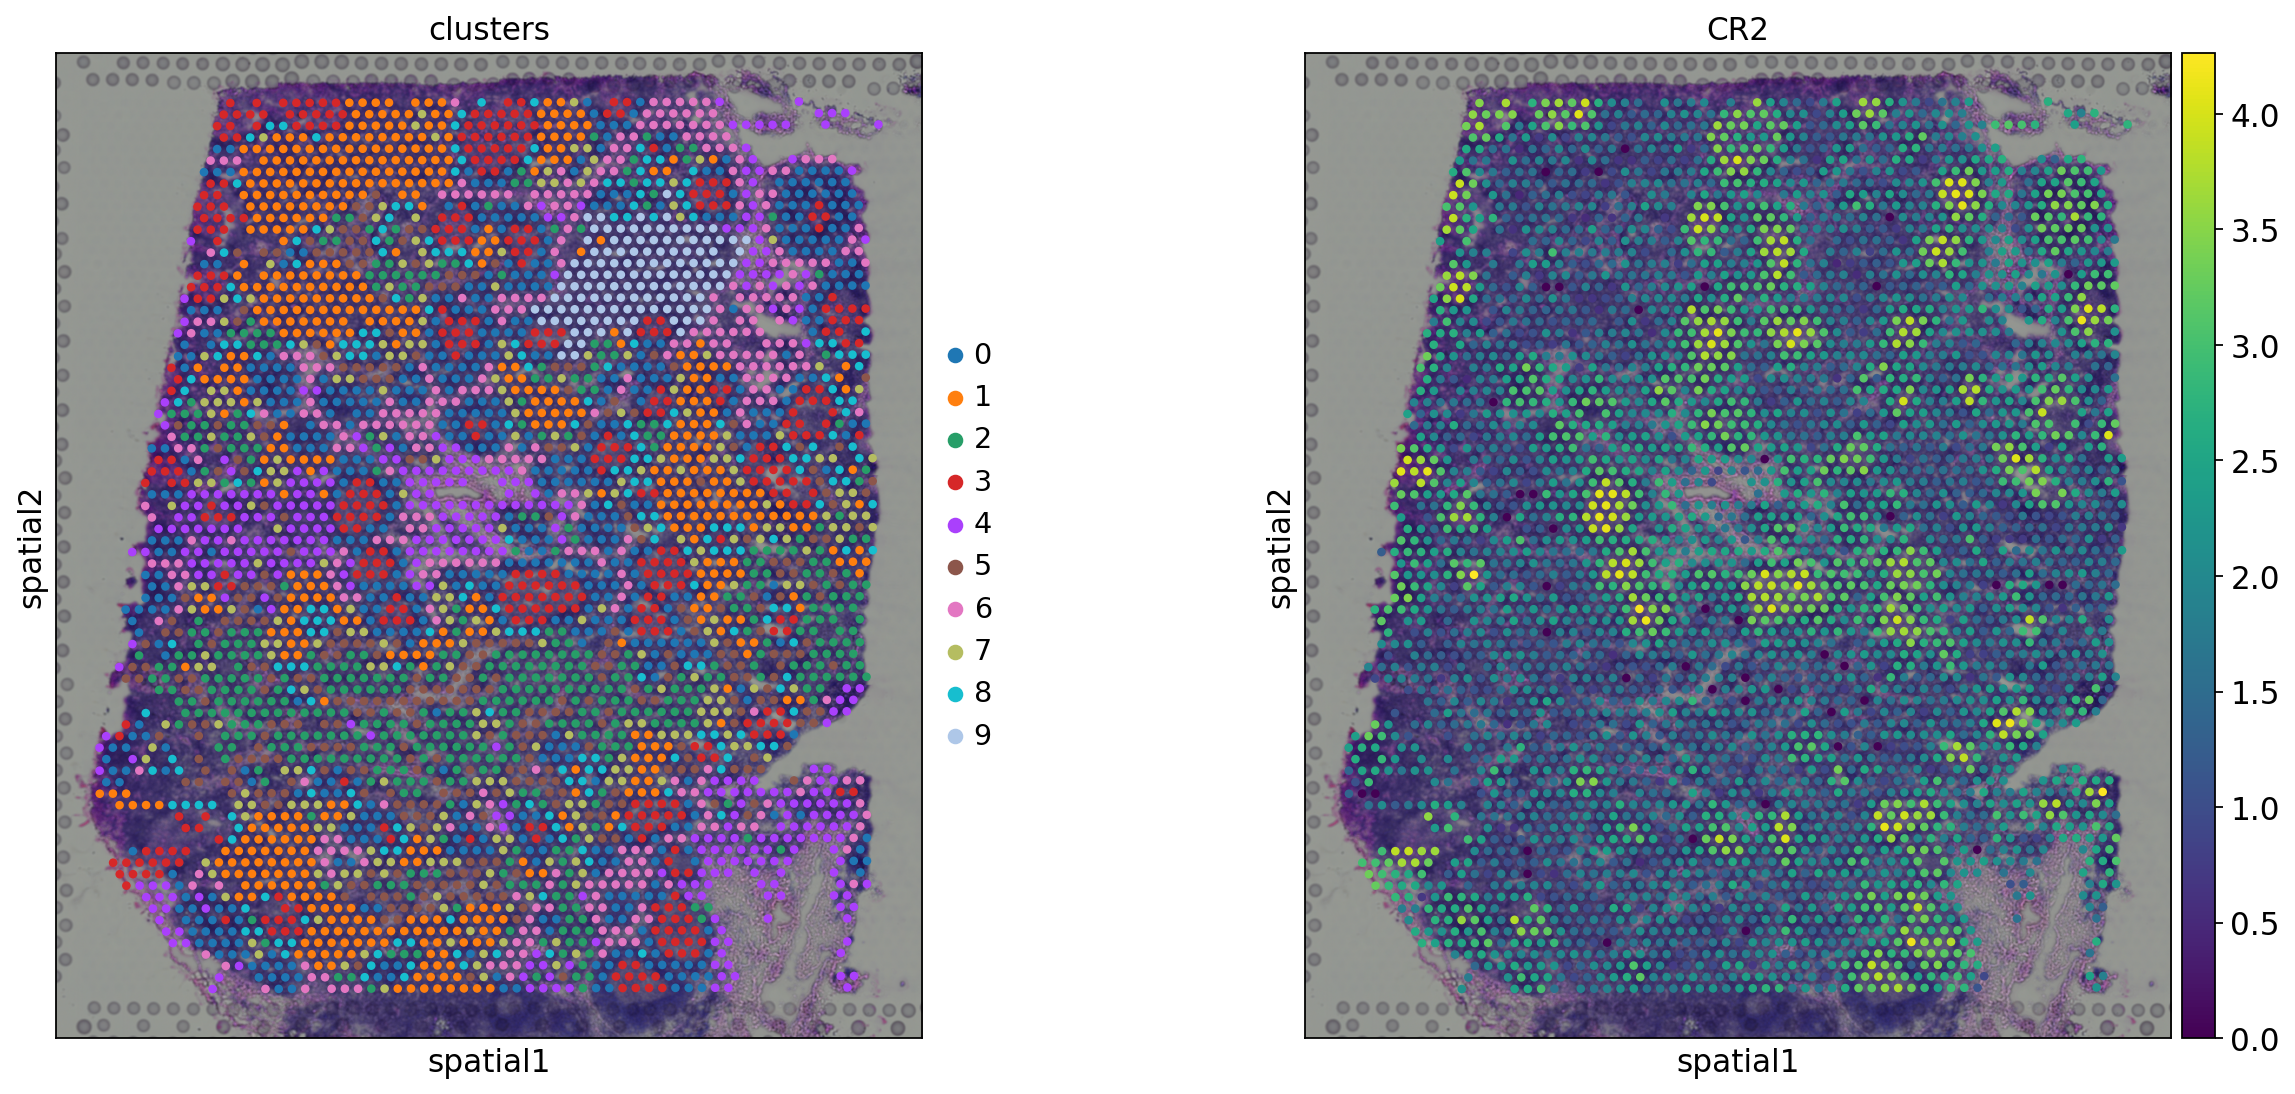

In [14]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])